# Feature Engineering with Deep AutoEncoder  

AutoEncoder는 입력 X를 encoding-decoding을 거쳐 자기 자신으로 복원하는 과정을 통해 X를 효과적으로 압축하고 표현할 수 있는 좋은 feature를 얻는 unsupervised learning 기법으로 관심을 받아 왔습니다. Vanilla AutoEncoder를 Generative model로서 사용하기에는 품질이 뛰어나지 못합니다만, Denoising AutoEncoder를 통한 노이즈 제거, 혹은 Variational AutoEncoder(VAE)를 통한 generation 기법으로 널리 활용되고 있습니다.  

또 한가지 중요한 AutoEncoder의 응용 분야는 Anomaly Detection입니다. AutoEncoder는 학습할 때 보았단 데이터의 분포에 대해서만 데이터의 복원을 위한 feature를 추출할 수 있습니다. 만약 학습할 때 보았던 데이터와 매우 이질적인 분포를 보이는 anomal한 데이터를 입력받게 된다면 추출된 feature도 이전과 매우 다른 분포를 보이게 될 것입니다. 이 분포상의 차이를 가지고 anomality를 판단하는 기준을 뽑아낼 수 있을 여지도 있습니다.  

이번 실습에서는 MNIST를 복원하는 AutoEncoder를 만드는 과정을 통해서 AutoEncoder의 구조와 원리를 이해해 보고자 합니다.  

(참고)   
https://blog.keras.io/building-autoencoders-in-keras.html  
https://www.datacamp.com/community/tutorials/autoencoder-keras-tutorial  
https://medium.com/datadriveninvestor/deep-autoencoder-using-keras-b77cd3e8be95

In [1]:
import numpy as np

from keras.layers import Input, Dense
from keras.models import Model

from keras.datasets import mnist
# from keras.preprocessing import image

import matplotlib.pyplot as plt #for plotting
%matplotlib inline

Using TensorFlow backend.


In [2]:
# to reproduce same training result
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

### prepare dataset for AutoEncoder

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

x_train.shape

(60000, 784)

In [4]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### AutoEncoder with Dense Layers  

우선 MNIST 데이터를 Dense Layer로 구성된 Encoder, Decoder로 다루어 보겠습니다.  
이 경우에는 (28,28, 1) 로 구성된 MNIST 데이터를 (784,)의 벡터로 다루어야 합니다.

In [5]:
# 784차원 이미지를 32차원으로 축소표현합니다.
input_dim = 784
encoding_dim = 32 
# this is our input placeholder
input_img = Input(shape=(784,))

In [7]:
encode_layer_1 = Dense(units=encoding_dim*4, activation='relu')
encode_layer_2 = Dense(units=encoding_dim*2, activation='relu')
encode_layer_3 = Dense(units=encoding_dim*1, activation='relu')
decode_layer_1 = Dense(units=encoding_dim*2, activation='relu')
decode_layer_2 = Dense(units=encoding_dim*4, activation='relu')
decode_layer_3 = Dense(units=input_dim, activation='sigmoid')

encoded = encode_layer_1(input_img)
encoded = encode_layer_2(encoded)
encoded = encode_layer_3(encoded)

decoded = decode_layer_1(encoded)
decoded = decode_layer_2(decoded)
decoded = decode_layer_3(decoded)

In [8]:
autoencoder=Model(input_img, decoded)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total para

### Extract Encoder

In [9]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


### Extract Decoder

In [10]:
# input placeholder for decoder
input_decoder = Input(shape=(encoding_dim,))

# "encoded" is the encoded representation of the input
output_decoder = decode_layer_1(input_decoder)
output_decoder = decode_layer_2(output_decoder)
output_decoder = decode_layer_3(output_decoder)

# this model maps an input to its encoded representation
decoder = Model(input_decoder, output_decoder)

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


### Training

In [11]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 112us/step - loss: 0.3354 - val_loss: 0.2637
Epoch 2/50
60000/60000 [==============================] - 2s 30us/step - loss: 0.2529 - val_loss: 0.2405
Epoch 3/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.2317 - val_loss: 0.2247
Epoch 4/50
60000/60000 [==============================] - ETA: 0s - loss: 0.218 - 2s 34us/step - loss: 0.2185 - val_loss: 0.2091
Epoch 5/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.2023 - val_loss: 0.1942
Epoch 6/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1913 - val_loss: 0.1859
Epoch 7/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1846 - val_loss: 0.1825
Epoch 8/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.1788 - val_loss: 0.1755
Epoch 9/50
60000/60000 [=============

### Reconstruction Test

In [31]:
x_test_10 = x_test[:10]
x_test_hat = autoencoder.predict(x_test_10)
z_test = encoder.predict(x_test_10)

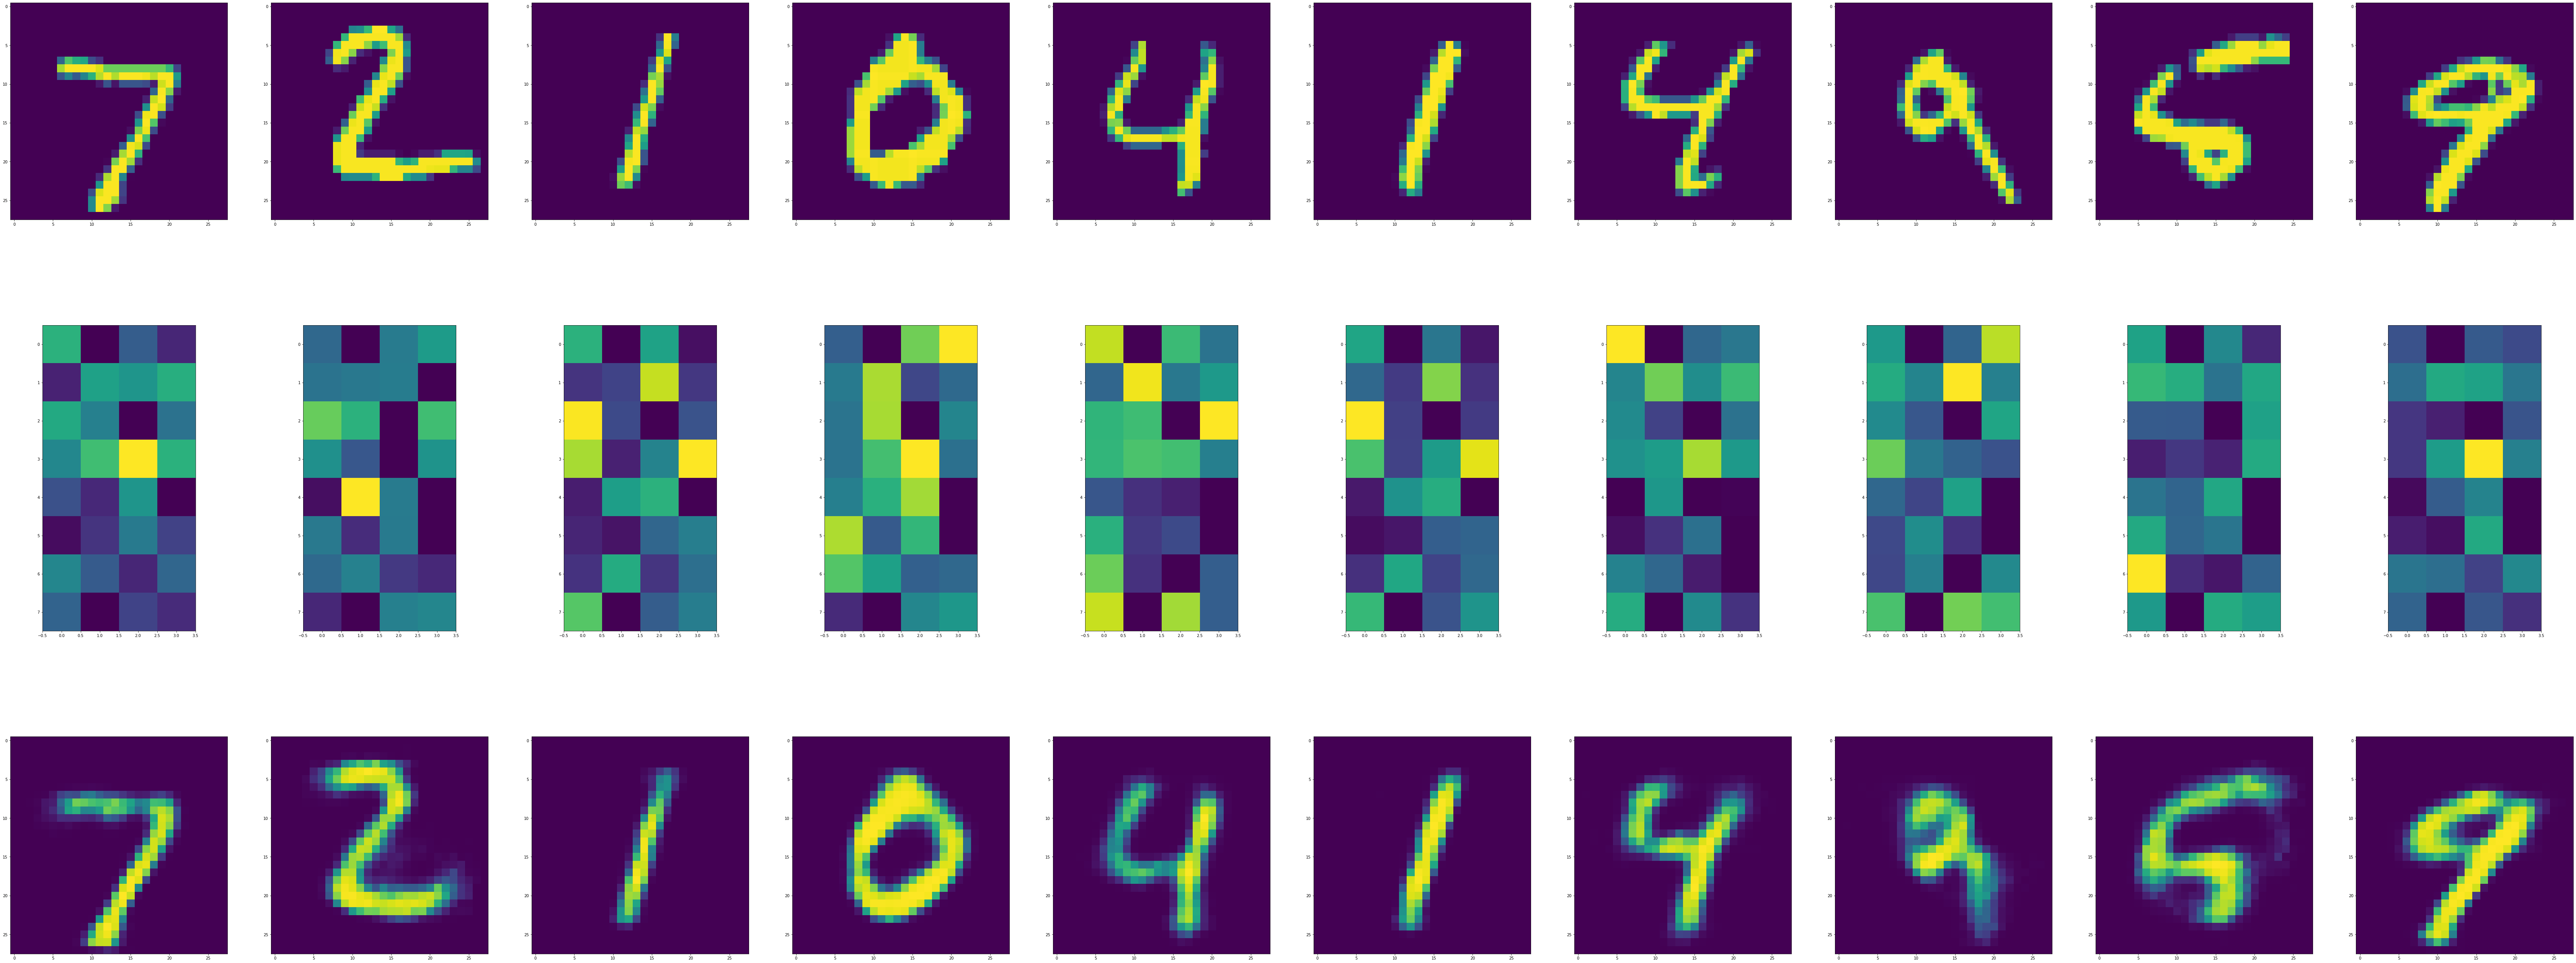

In [32]:
x_test_imgs = x_test_10.reshape(-1, 28, 28)
x_test_hat_imgs = x_test_hat.reshape(-1, 28, 28)
z_test = z_test.reshape(-1, 8, 4)

plt.figure(figsize=(120,50))
for i in range(10):  
    # 원본이미지 출력
    plt.subplot(3, 10, i+1)
    plt.imshow(x_test_imgs[i])
    # hidden feature 출력
    plt.subplot(3, 10, i+11)
    plt.imshow(z_test[i])
    # 생성된 이미지 출력
    plt.subplot(3, 10, i+21)
    plt.imshow(x_test_hat_imgs[i])

## Decoder 동작 확인  

hidden feature z 를 알고 있다면 decoder만 이용해서 동일하게 이미지를 복원할 수 있습니다.

In [34]:
z_test = z_test.reshape(-1, 32)

decoder_test_hat = decoder.predict(z_test)

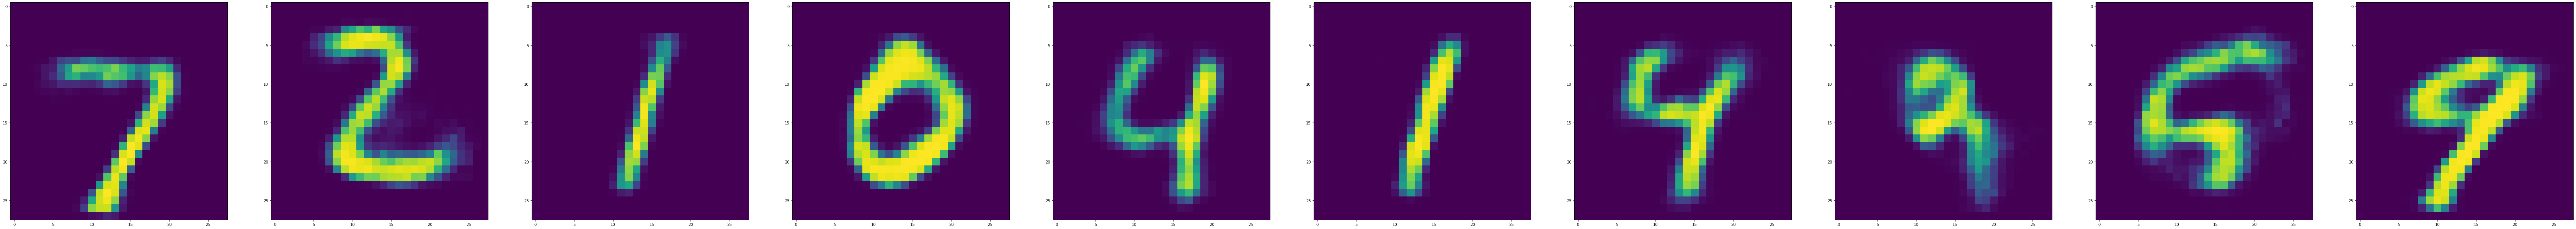

In [35]:
decoder_test_imgs = decoder_test_hat.reshape(-1, 28, 28)

plt.figure(figsize=(120,20))
for i in range(10):  
    # 생성된 이미지 출력
    plt.subplot(1, 10, i+1)
    plt.imshow(decoder_test_imgs[i])